In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)


df = pd.read_csv('/kaggle/input/data-science-salaries/data_science_salaries.csv') # DATASET name; double-check


print(f"\nChecking data:")

print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

print("\nColumn names and types:")
print(df.dtypes)

print("\nMemory usage:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

#PREVIEW

print("\nFirst 5 rows:")
print(df.head())

print("\nLast 5 rows:")
print(df.tail())

print("\nRandom sample (5 rows):")
print(df.sample(5, random_state=42))

# Check missing values
print("\nMissing values per column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("✓ No missing values found!")

# Check Duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# FINISH checking

# Numerical columns
print("\nNumerical columns:")
print(df.describe())

for col in df.columns:
    print(f"\n--- {col} ---")
    print(f"Type: {df[col].dtype}")
    print(f"Unique values: {df[col].nunique()}")
    
    # Show value counts for categorical columns (if not too many)
    if df[col].dtype == 'object' or df[col].nunique() < 20:
        print(f"Value distribution:")
        print(df[col].value_counts().head(10))
    else:
        print(f"Range: {df[col].min()} to {df[col].max()}")
        print(f"Mean: {df[col].mean():.2f}")
        print(f"Median: {df[col].median():.2f}")

/kaggle/input/data-science-salaries/data_science_salaries.csv
DATA SCIENCE SALARIES - INITIAL EXPLORATION

✓ Data loaded successfully!

DATASET OVERVIEW

Dataset shape: 6,599 rows × 11 columns

Column names and types:
job_title             object
experience_level      object
employment_type       object
work_models           object
work_year              int64
employee_residence    object
salary                 int64
salary_currency       object
salary_in_usd          int64
company_location      object
company_size          object
dtype: object

Memory usage:
3.50 MB

DATA PREVIEW

First 5 rows:
        job_title experience_level employment_type work_models  work_year  \
0   Data Engineer        Mid-level       Full-time      Remote       2024   
1   Data Engineer        Mid-level       Full-time      Remote       2024   
2  Data Scientist     Senior-level       Full-time      Remote       2024   
3  Data Scientist     Senior-level       Full-time      Remote       2024   
4    BI Deve

In [3]:
# Create a copy for processing
df_clean = df.copy()

print(f"\nStarting with {len(df_clean):,} rows")

# check for extremes/outliers (IQR)

Q1 = df_clean['salary_in_usd'].quantile(0.25)
Q3 = df_clean['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers only
upper_bound = Q3 + 3 * IQR

outliers = df_clean[(df_clean['salary_in_usd'] < lower_bound) | 
                     (df_clean['salary_in_usd'] > upper_bound)]

print(f"\nSalary statistics:")
print(f"  Q1 (25%): ${Q1:,.0f}")
print(f"  Q3 (75%): ${Q3:,.0f}")
print(f"  IQR: ${IQR:,.0f}")
print(f"  Outlier bounds: ${lower_bound:,.0f} - ${upper_bound:,.0f}")
print(f"\nExtreme outliers found: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)")

if len(outliers) > 0:
    print("\nExtreme outlier examples:")
    print(outliers[['job_title', 'experience_level', 'salary_in_usd']].head())

# Keep outliers for now (real data), but flag
df_clean['is_outlier'] = ((df_clean['salary_in_usd'] < lower_bound) | 
                           (df_clean['salary_in_usd'] > upper_bound)).astype(int)

# Feature 1: Years since data collection (experience proxy)
df_clean['years_from_2020'] = df_clean['work_year'] - 2020

# Feature 2: Is US-based? (large majority are US)
df_clean['is_us'] = (df_clean['company_location'] == 'United States').astype(int)

# Feature 3: Remote work indicator
df_clean['is_remote'] = (df_clean['work_models'] == 'Remote').astype(int)
df_clean['is_hybrid'] = (df_clean['work_models'] == 'Hybrid').astype(int)

# Feature 4: Senior+ indicator (Senior or Executive)
df_clean['is_senior_plus'] = df_clean['experience_level'].isin(
    ['Senior-level', 'Executive-level']
).astype(int)

# Feature 5: Top job categories (simplify 132 job titles)
top_jobs = df_clean['job_title'].value_counts().head(10).index.tolist()
df_clean['job_category'] = df_clean['job_title'].apply(
    lambda x: x if x in top_jobs else 'Other'
)

# Feature 6: Experience level as ordinal
experience_order = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior-level': 3,
    'Executive-level': 4
}
df_clean['experience_numeric'] = df_clean['experience_level'].map(experience_order)

# Feature 7: Company size as ordinal
size_order = {
    'Small': 1,
    'Medium': 2,
    'Large': 3
}
df_clean['company_size_numeric'] = df_clean['company_size'].map(size_order)

print("\n✓ New features created:")
print("  - years_from_2020 (time trend)")
print("  - is_us (location indicator)")
print("  - is_remote, is_hybrid (work model flags)")
print("  - is_senior_plus (seniority flag)")
print("  - job_category (simplified job titles)")
print("  - experience_numeric (ordinal encoding)")
print("  - company_size_numeric (ordinal encoding)")

print(f"\nNew dataset shape: {df_clean.shape}")

# DATA validation

print("\nChecking new features:")
print(f"  - years_from_2020 range: {df_clean['years_from_2020'].min()} to {df_clean['years_from_2020'].max()}")
print(f"  - US companies: {df_clean['is_us'].sum()} ({df_clean['is_us'].mean()*100:.1f}%)")
print(f"  - Remote workers: {df_clean['is_remote'].sum()} ({df_clean['is_remote'].mean()*100:.1f}%)")
print(f"  - Senior+ level: {df_clean['is_senior_plus'].sum()} ({df_clean['is_senior_plus'].mean()*100:.1f}%)")

print("\nJob categories created:")
print(df_clean['job_category'].value_counts())


# Full dataset with all features
df_full = df_clean.copy()

# Remove extreme outliers for main analysis (but keep flagged)
df_main = df_clean[df_clean['salary_in_usd'] <= 500000].copy()
print(f"\n✓ Main dataset (salary ≤ $500k): {len(df_main):,} rows")
print(f"  Removed {len(df_clean) - len(df_main)} extreme outliers for cleaner analysis")

# Save datasets for next steps
df_full.to_csv('ds_salaries_full.csv', index=False)
df_main.to_csv('ds_salaries_clean.csv', index=False)

print("\n✓ Datasets saved:")
print("  - ds_salaries_full.csv (all data with outliers)")
print("  - ds_salaries_clean.csv (main analysis dataset)")


print(f"\n📊 Dataset ready for analysis:")
print(f"  - Original rows: {len(df):,}")
print(f"  - Analysis rows: {len(df_main):,}")
print(f"  - Features: {len(df_main.columns)}")
print(f"  - Target variable: salary_in_usd")

STEP 2: DATA CLEANING & FEATURE ENGINEERING

Starting with 6,599 rows

2.1: OUTLIER DETECTION

Salary statistics:
  Q1 (25%): $95,000
  Q3 (75%): $185,000
  IQR: $90,000
  Outlier bounds: $-175,000 - $455,000

Extreme outliers found: 10 (0.2%)

Extreme outlier examples:
                      job_title experience_level  salary_in_usd
296  Machine Learning Scientist        Mid-level         750000
321           Research Engineer        Mid-level         720000
329          Research Scientist        Mid-level         720000
848  Machine Learning Scientist        Mid-level         750000
852   Machine Learning Engineer        Mid-level         750000

2.2: FEATURE ENGINEERING

✓ New features created:
  - years_from_2020 (time trend)
  - is_us (location indicator)
  - is_remote, is_hybrid (work model flags)
  - is_senior_plus (seniority flag)
  - job_category (simplified job titles)
  - experience_numeric (ordinal encoding)
  - company_size_numeric (ordinal encoding)

New dataset shape: (65

STEP 3: EXPLORATORY DATA ANALYSIS

✓ Loaded 6,590 records for analysis

Creating visualization 1/10: Salary Distribution...


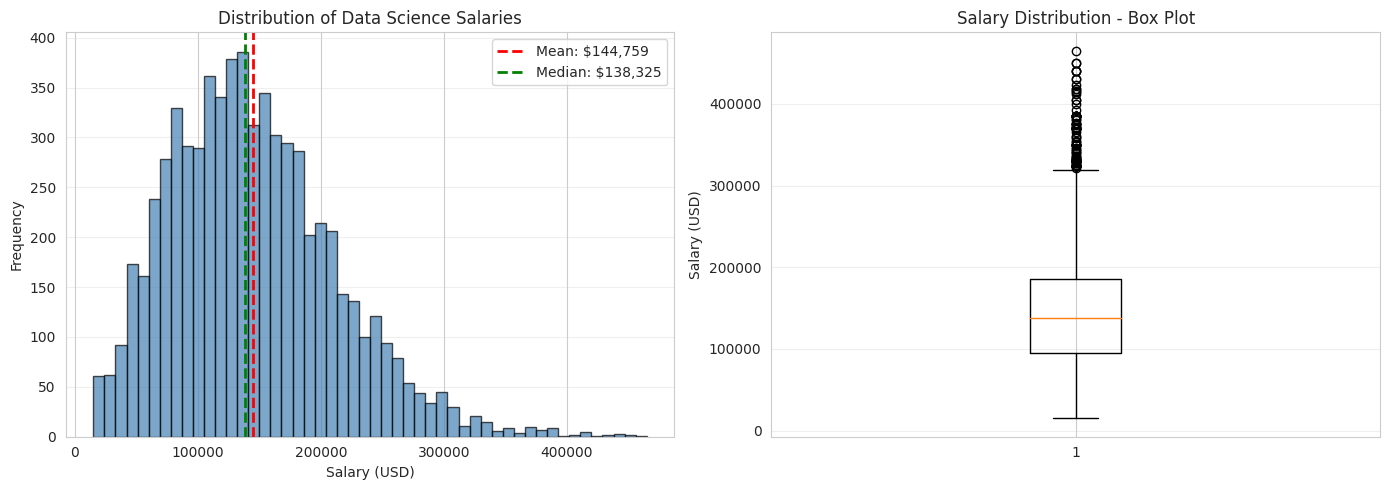

Creating visualization 2/10: Salary by Experience Level...


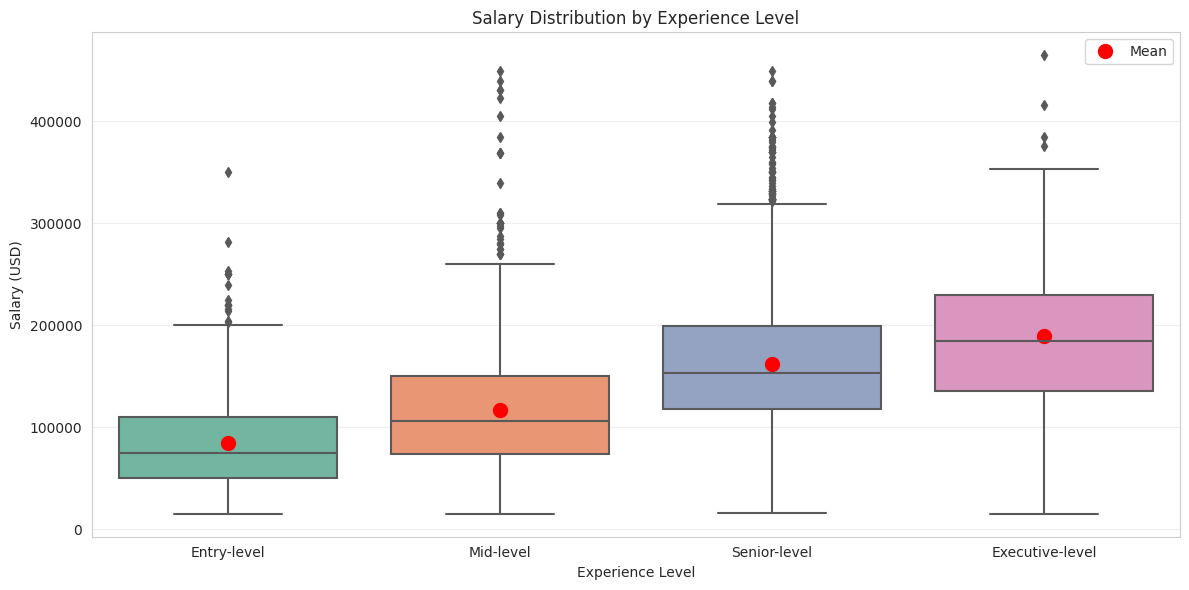


Salary by Experience Level:
                  count           mean    median           std
experience_level                                              
Executive-level     254  189687.346457  184560.0  71571.166828
Senior-level       4103  161796.664879  153600.0  63247.784091
Mid-level          1668  116437.761391  106500.0  59805.298743
Entry-level         565   84448.916814   75000.0  48758.315152

Creating visualization 3/10: Salary by Top Job Titles...


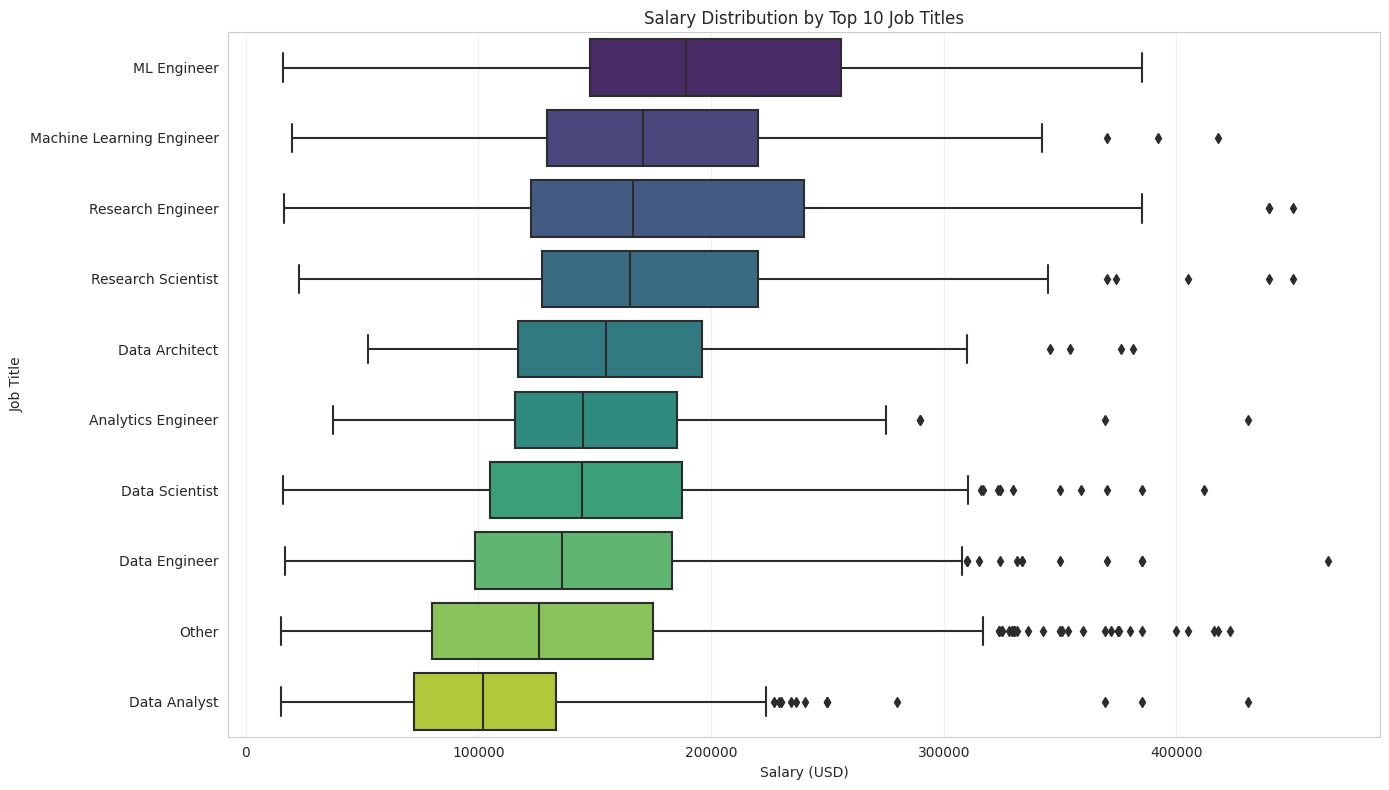

Creating visualization 4/10: Salary Trends Over Time...


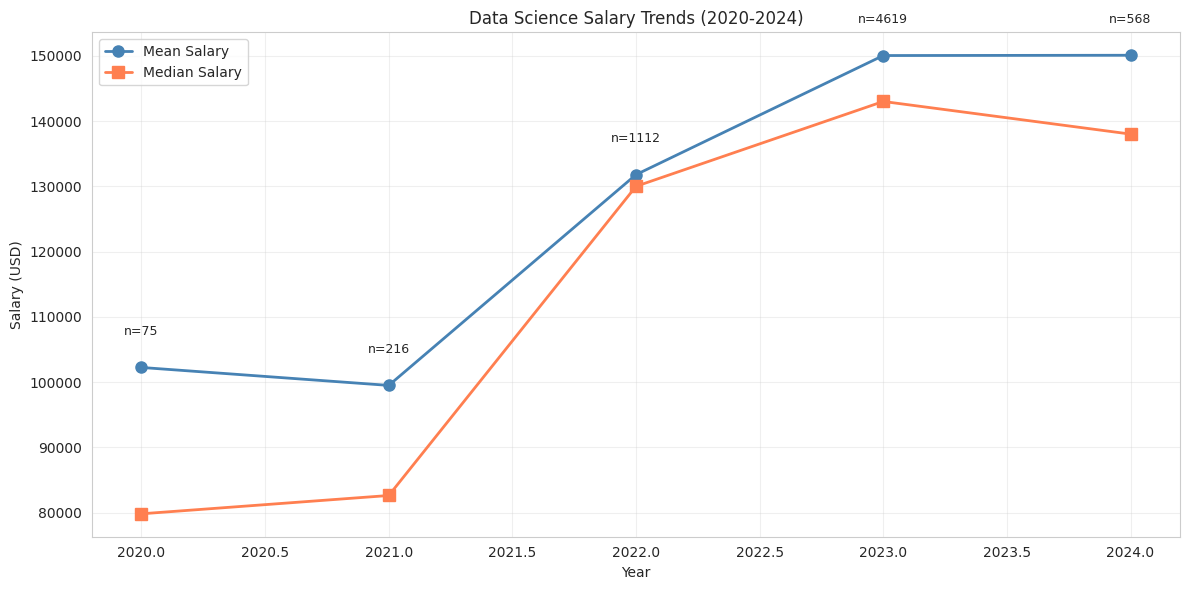


Yearly Salary Statistics:
                    mean    median  count
work_year                                
2020       102250.866667   79833.0     75
2021        99501.287037   82636.0    216
2022       131788.543165  130000.0   1112
2023       150034.709028  143000.0   4619
2024       150077.204225  138000.0    568

Creating visualization 5/10: Work Model Comparison...


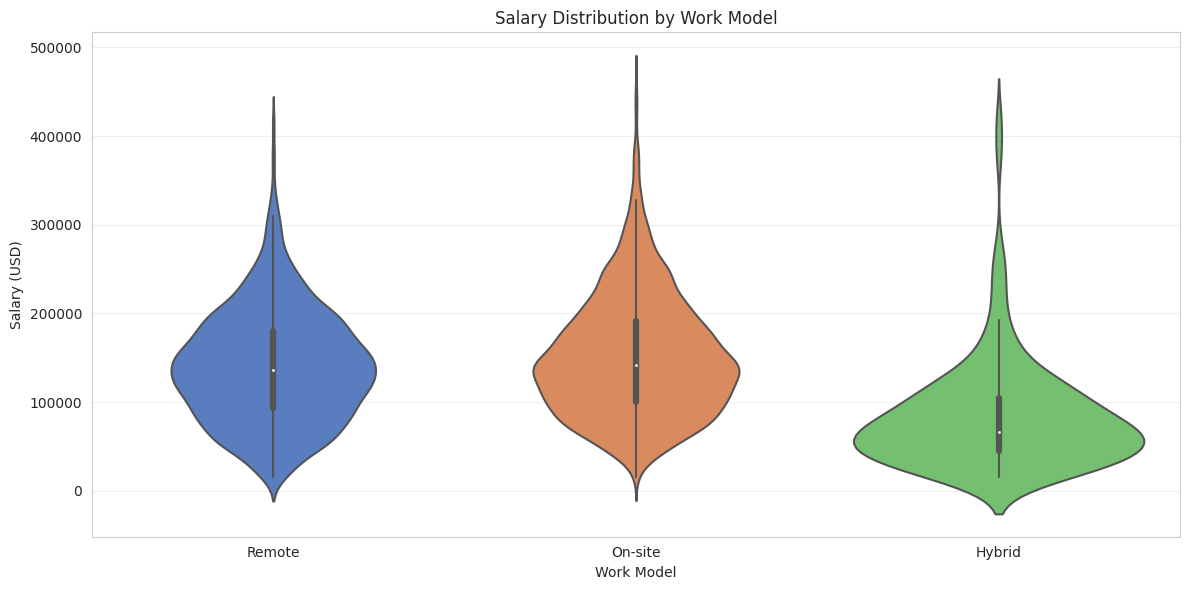


Salary by Work Model:
             count           mean    median
work_models                                
On-site       3806  151517.126905  142200.0
Remote        2559  140112.896835  136000.0
Hybrid         225   83293.502222   66192.0

Creating visualization 6/10: Salary by Country...


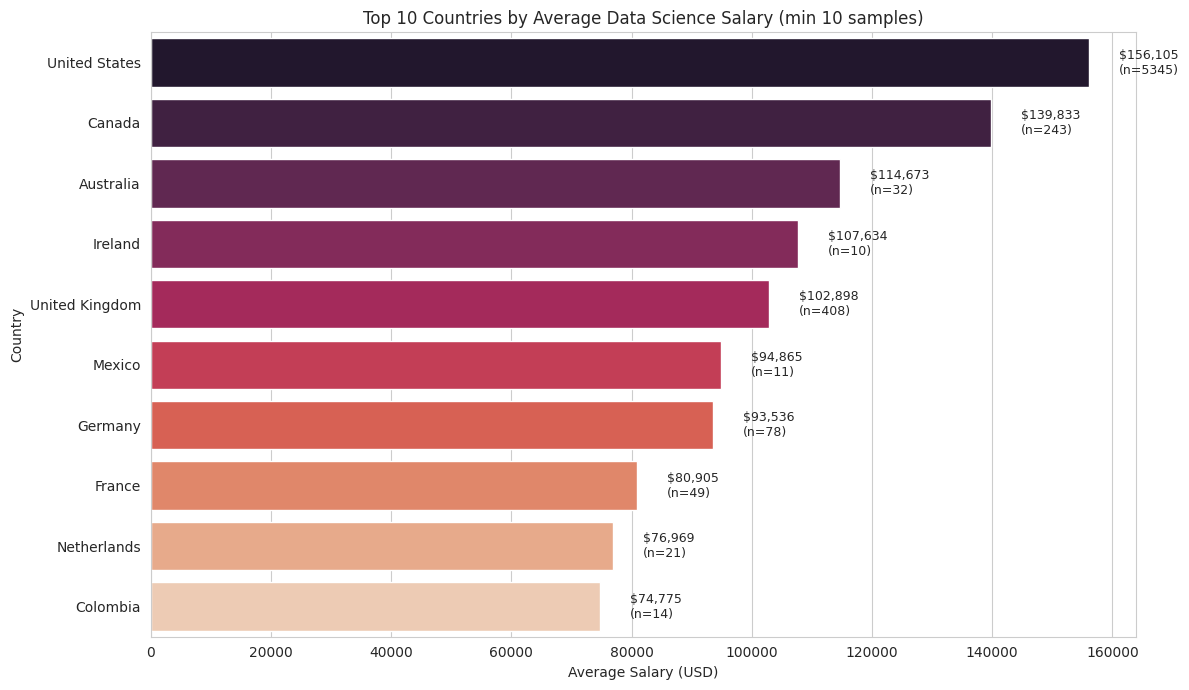

Creating visualization 7/10: Salary by Company Size...


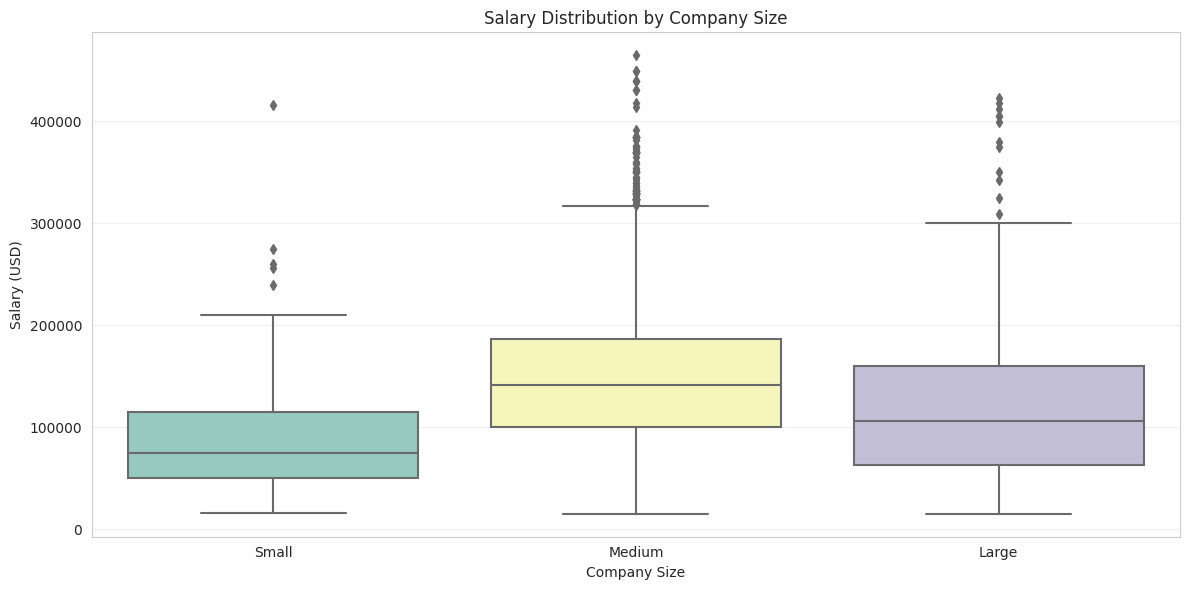


Salary by Company Size:
              count           mean    median
company_size                                
Small           170   87687.458824   74500.0
Medium         5851  148763.289352  141300.0
Large           569  120638.404218  106000.0

Creating visualization 8/10: Feature Correlations...


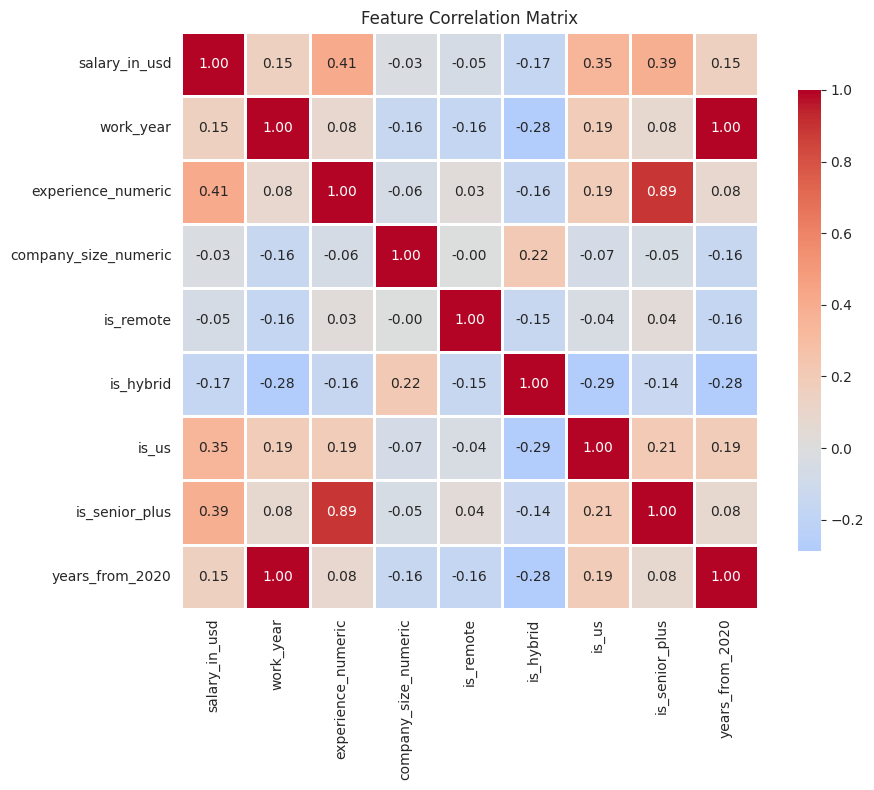

Creating visualization 9/10: Experience vs Salary...


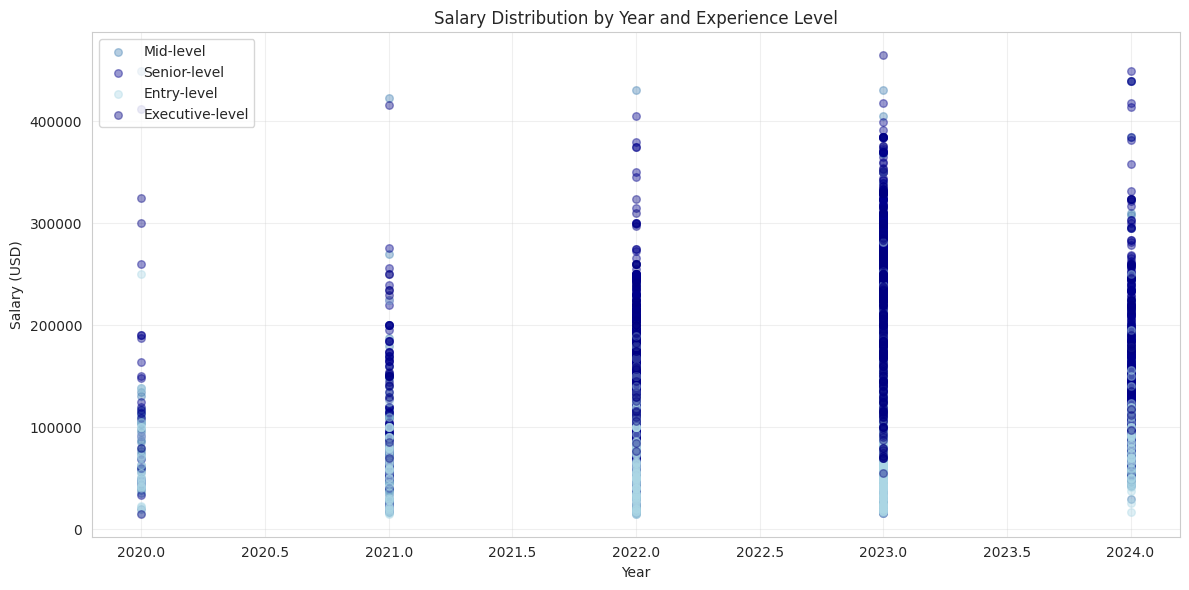

Creating visualization 10/10: Summary Dashboard...


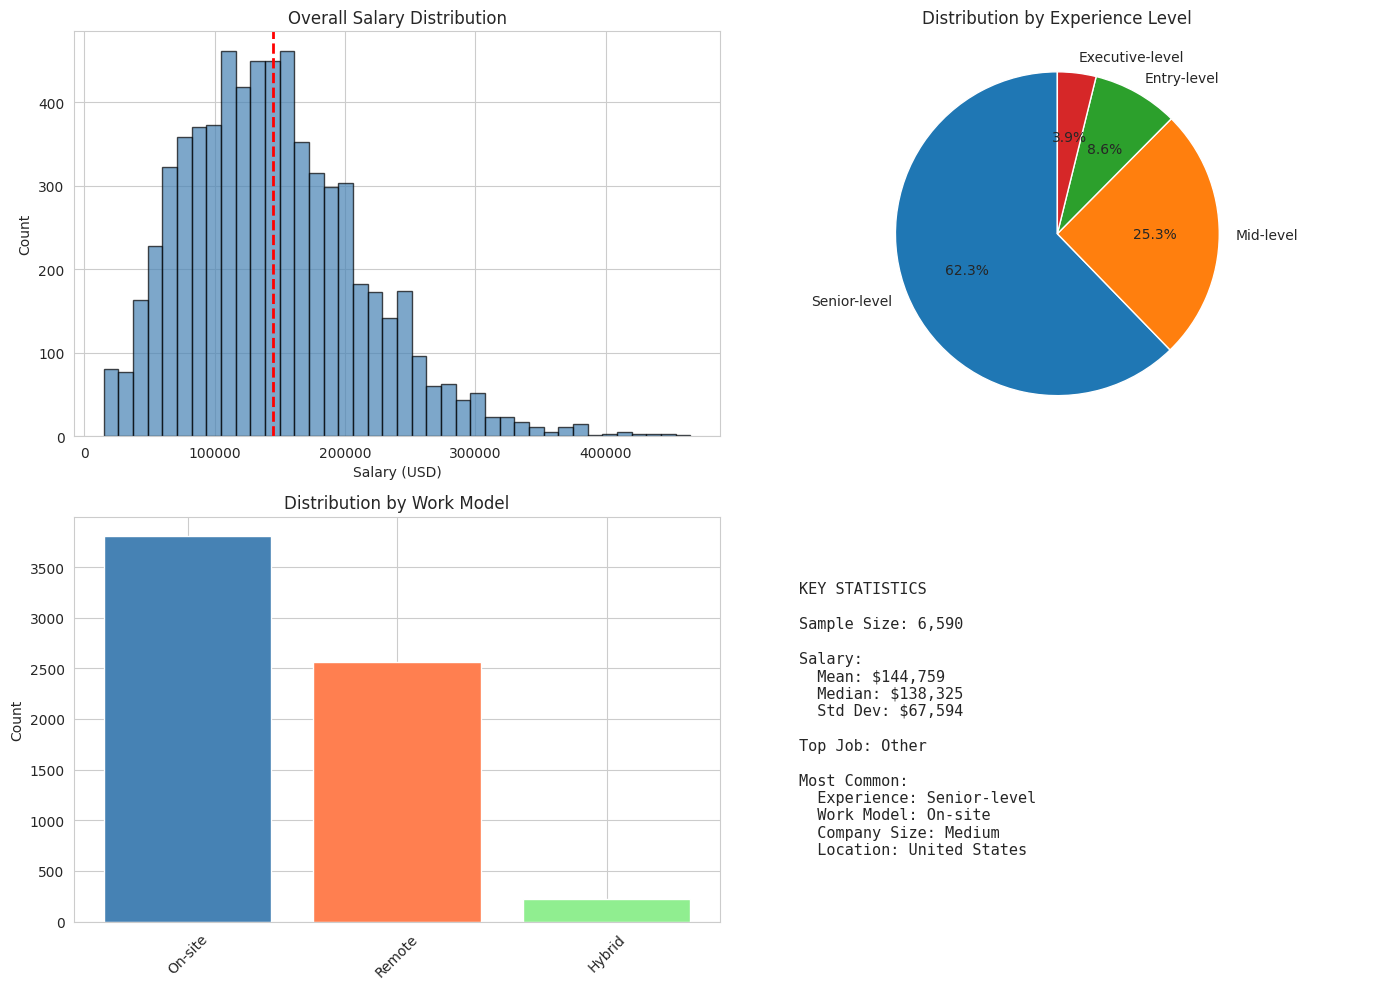


✅ ALL VISUALIZATIONS CREATED

10 visualizations saved:
  1. viz1_salary_distribution.png
  2. viz2_salary_by_experience.png
  3. viz3_salary_by_job.png
  4. viz4_salary_trends.png
  5. viz5_work_model.png
  6. viz6_salary_by_country.png
  7. viz7_company_size.png
  8. viz8_correlations.png
  9. viz9_experience_scatter.png
  10. viz10_summary_dashboard.png

✅ READY FOR STEP 4: PREDICTIVE MODELING


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis and visualisation

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the clean dataset
df = pd.read_csv('ds_salaries_clean.csv')
print(f"\n✓ Loaded {len(df):,} records for analysis\n")

print("Creating visualization 1/10: Salary Distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['salary_in_usd'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["salary_in_usd"].mean():,.0f}')
axes[0].axvline(df['salary_in_usd'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df["salary_in_usd"].median():,.0f}')
axes[0].set_xlabel('Salary (USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Data Science Salaries')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df['salary_in_usd'], vert=True)
axes[1].set_ylabel('Salary (USD)')
axes[1].set_title('Salary Distribution - Box Plot')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('viz1_salary_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating visualization 2/10: Salary by Experience Level...")

plt.figure(figsize=(12, 6))
order = ['Entry-level', 'Mid-level', 'Senior-level', 'Executive-level']
sns.boxplot(data=df, x='experience_level', y='salary_in_usd', order=order, palette='Set2')
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')
plt.title('Salary Distribution by Experience Level')

# Add mean values as points
means = df.groupby('experience_level')['salary_in_usd'].mean()
positions = range(len(order))
for i, exp in enumerate(order):
    if exp in means.index:
        plt.plot(i, means[exp], 'ro', markersize=10, label='Mean' if i == 0 else '')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('viz2_salary_by_experience.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nSalary by Experience Level:")
exp_stats = df.groupby('experience_level')['salary_in_usd'].agg(['count', 'mean', 'median', 'std'])
print(exp_stats.sort_values('mean', ascending=False))

print("\nCreating visualization 3/10: Salary by Top Job Titles...")

top_10_jobs = df['job_category'].value_counts().head(10).index
df_top_jobs = df[df['job_category'].isin(top_10_jobs)]

plt.figure(figsize=(14, 8))
job_order = df_top_jobs.groupby('job_category')['salary_in_usd'].median().sort_values(ascending=False).index
sns.boxplot(data=df_top_jobs, y='job_category', x='salary_in_usd', order=job_order, palette='viridis')
plt.xlabel('Salary (USD)')
plt.ylabel('Job Title')
plt.title('Salary Distribution by Top 10 Job Titles')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('viz3_salary_by_job.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating visualization 4/10: Salary Trends Over Time...")

yearly_stats = df.groupby('work_year')['salary_in_usd'].agg(['mean', 'median', 'count'])

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2, markersize=8, label='Mean Salary', color='steelblue')
ax1.plot(yearly_stats.index, yearly_stats['median'], marker='s', linewidth=2, markersize=8, label='Median Salary', color='coral')
ax1.set_xlabel('Year')
ax1.set_ylabel('Salary (USD)')
ax1.set_title('Data Science Salary Trends (2020-2024)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Add sample size as text
for year, count in yearly_stats['count'].items():
    ax1.text(year, yearly_stats['mean'][year] + 5000, f'n={count}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('viz4_salary_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nYearly Salary Statistics:")
print(yearly_stats)

print("\nCreating visualization 5/10: Work Model Comparison...")

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='work_models', y='salary_in_usd', palette='muted')
plt.xlabel('Work Model')
plt.ylabel('Salary (USD)')
plt.title('Salary Distribution by Work Model')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('viz5_work_model.png', dpi=300, bbox_inches='tight')
plt.show()

work_stats = df.groupby('work_models')['salary_in_usd'].agg(['count', 'mean', 'median'])
print("\nSalary by Work Model:")
print(work_stats.sort_values('mean', ascending=False))

print("\nCreating visualization 6/10: Salary by Country...")

country_stats = df.groupby('company_location')['salary_in_usd'].agg(['count', 'mean']).reset_index()
country_stats = country_stats[country_stats['count'] >= 10]  # At least 10 samples
top_10_countries = country_stats.nlargest(10, 'mean')

plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_countries, y='company_location', x='mean', palette='rocket')
plt.xlabel('Average Salary (USD)')
plt.ylabel('Country')
plt.title('Top 10 Countries by Average Data Science Salary (min 10 samples)')

for i, row in enumerate(top_10_countries.itertuples()):
    plt.text(row.mean + 5000, i, f'${row.mean:,.0f}\n(n={int(row.count)})', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('viz6_salary_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating visualization 7/10: Salary by Company Size...")

plt.figure(figsize=(12, 6))
size_order = ['Small', 'Medium', 'Large']
sns.boxplot(data=df, x='company_size', y='salary_in_usd', order=size_order, palette='Set3')
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')
plt.title('Salary Distribution by Company Size')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('viz7_company_size.png', dpi=300, bbox_inches='tight')
plt.show()

size_stats = df.groupby('company_size')['salary_in_usd'].agg(['count', 'mean', 'median'])
print("\nSalary by Company Size:")
print(size_stats.reindex(size_order))

print("\nCreating visualization 8/10: Feature Correlations...")

# Select numeric features for correlation
numeric_features = ['salary_in_usd', 'work_year', 'experience_numeric', 'company_size_numeric', 
                     'is_remote', 'is_hybrid', 'is_us', 'is_senior_plus', 'years_from_2020']

corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('viz8_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating visualization 9/10: Experience vs Salary...")

plt.figure(figsize=(12, 6))
colors = {'Entry-level': 'lightblue', 'Mid-level': 'steelblue', 
          'Senior-level': 'darkblue', 'Executive-level': 'navy'}

for exp_level in df['experience_level'].unique():
    subset = df[df['experience_level'] == exp_level]
    plt.scatter(subset['work_year'], subset['salary_in_usd'], 
                alpha=0.4, s=30, label=exp_level, color=colors.get(exp_level, 'gray'))

plt.xlabel('Year')
plt.ylabel('Salary (USD)')
plt.title('Salary Distribution by Year and Experience Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('viz9_experience_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating visualization 10/10: Summary Dashboard...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Overall distribution
axes[0, 0].hist(df['salary_in_usd'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Overall Salary Distribution')
axes[0, 0].set_xlabel('Salary (USD)')
axes[0, 0].set_ylabel('Count')

# Top-right: Experience breakdown
exp_counts = df['experience_level'].value_counts()
axes[0, 1].pie(exp_counts.values, labels=exp_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Distribution by Experience Level')

# Bottom-left: Work model breakdown
work_counts = df['work_models'].value_counts()
axes[1, 0].bar(work_counts.index, work_counts.values, color=['steelblue', 'coral', 'lightgreen'])
axes[1, 0].set_title('Distribution by Work Model')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Bottom-right: Key statistics
stats_text = f"""
KEY STATISTICS

Sample Size: {len(df):,}

Salary:
  Mean: ${df['salary_in_usd'].mean():,.0f}
  Median: ${df['salary_in_usd'].median():,.0f}
  Std Dev: ${df['salary_in_usd'].std():,.0f}

Top Job: {df['job_category'].mode()[0]}

Most Common:
  Experience: {df['experience_level'].mode()[0]}
  Work Model: {df['work_models'].mode()[0]}
  Company Size: {df['company_size'].mode()[0]}
  Location: {df['company_location'].mode()[0]}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace', verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('viz10_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# END